In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si

In [87]:
cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker']
cols_to_drop = ["Date", "adjclose", "ticker"]
cols_to_exclude = []#["volume"]
cols_to_keep = list(set(cols).difference(cols_to_drop).difference(cols_to_exclude))
cols_to_keep

['close', 'adjclose', 'low', 'high', 'open', 'volume', 'ticker']

In [89]:
#2005-07-28
stocks = {"YESBANK.NS" : 0.4, "TATAMOTORS.NS":0.6}
df = None
indices = set([])

for stock in stocks.keys():
    _df = si.get_data(stock)
    _df.dropna(inplace=True)
    # print("\n")
    # print(stock , " ", _df.loc["2019-02-25"])
    if df is None:
        df = _df[cols_to_keep]*stocks.get(stock)
        indices = set(df.index.astype('str').tolist())
    else:
        indices.intersection(set(_df.index.astype('str').tolist()))
        df = df.loc[indices]
        _df = _df.loc[indices]
        df[cols_to_keep] += _df[cols_to_keep]*stocks.get(stock)

# print(len(df))
df.head()

TypeError: can't multiply sequence by non-int of type 'float'

In [44]:
df.index.min(), df.index.max()
_df.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [45]:
# df = pd.read_csv("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/GoogleStockPricePrediction/GOOG2.csv")
# df = pd.read_csv("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/TATAMOTORS.NS test.csv")
# df.head()

In [46]:
df.dropna(inplace=True)
df = df.reset_index()
df.rename(columns = {'index':'Date'}, inplace = True)
df.drop(["volume"],axis=1,inplace=True)
df.head()

,Date,close,low,high,open
0,2019-02-25,197.090002,192.579999,198.740002,194.629999
1,2020-01-09,134.120000,129.070000,135.050000,129.710004
2,2017-02-06,427.385986,425.360010,431.730005,429.540015
3,2005-12-07,70.065398,68.941400,70.289602,69.382800
4,2009-10-23,83.350200,82.317001,86.298199,85.299800


In [47]:
df["Date"].min(), df["Date"].max()

(Timestamp('2005-07-12 00:00:00'), Timestamp('2020-11-06 00:00:00'))

In [76]:
mdf = df[:100]
mdf.head()
print(len(mdf))
mdf.sort_values('Date')

100


,Date,close,low,high,open
36,2005-11-02,60.543842,59.728739,61.405421,61.060482
11,2005-11-08,62.856881,61.642360,63.470802,61.718359
65,2005-11-17,66.343601,65.126219,66.907800,66.385598
3,2005-12-07,70.065398,68.941400,70.289602,69.382800
80,2006-03-06,113.659995,111.450401,115.396200,111.510402
...,...,...,...,...,...
9,2020-01-17,134.080002,132.219998,135.489998,133.389999
52,2020-03-16,64.609998,59.739998,68.750002,62.039999
26,2020-08-13,85.029996,80.900001,85.959996,82.479999
34,2020-08-21,78.760001,78.210001,80.959998,80.919998


,Date,close,low,high,open
1901,2005-07-12,58.643362,56.425259,59.915779,56.897260
3476,2005-07-13,57.701019,57.256080,59.413261,58.804821
2594,2005-07-14,56.952618,56.679658,58.374179,57.684302
1452,2005-07-15,58.274982,56.613959,58.620920,56.941621
874,2005-07-18,59.001099,58.378700,59.295839,58.434961


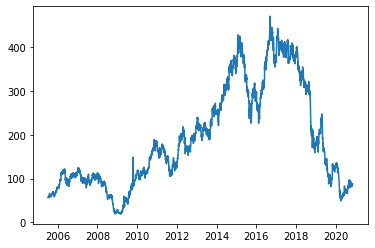

In [83]:
df= df.sort_values('Date')
split_date = '2020-01-01'
df_data_training = df[df["Date"]<split_date]
df_data_test = df[df["Date"]>=split_date]
plt.plot(df["Date"],df["open"])
df.head()

In [84]:
df_data_training.head()
print("Training Size : {}, Test Size : {}".format(len(df_data_training), len(df_data_test)) )

Training Size : 3555, Test Size : 214


In [85]:
data_training = df_data_training.drop(["Date", "adjclose", "ticker"], axis=1)
data_training.dropna(inplace=True)

KeyError: "['adjclose' 'ticker'] not found in axis"

In [ ]:
scaler = MinMaxScaler()
training_Dataset = scaler.fit_transform(data_training)
training_Dataset.shape

In [ ]:
training_window = 60
X_train = []
y_train = []
for i in range(training_window, training_Dataset.shape[0]):
    X_train.append(training_Dataset[i-training_window:i])
    y_train.append(training_Dataset[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
print("Shape of X is : {}, Shape of Y is : {}".format(X_train.shape,y_train.shape))

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
X_train.shape[1]
tf.optimizers

In [ ]:
model = Sequential([
    LSTM(units=120, activation='relu', return_sequences = True, input_shape = (60,5)),
    Dropout(0.2),
    LSTM(units=90, activation='relu', return_sequences = True),
    Dropout(0.2),
    LSTM(units=80, activation='relu', return_sequences = True),
    Dropout(0.2),
    LSTM(units=70, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.summary()

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if logs["loss"] < 1e-03:
            print("\nFinal Loss : {}".format(logs["loss"]))
            self.model.stop_training = True

In [ ]:
model.compile(optimizer= tf.optimizers.RMSprop() , loss= tf.losses.MeanSquaredError())
X_train.shape, y_train.shape
model.fit(X_train,y_train, epochs=500, callbacks = CustomCallback())

In [ ]:
test_pred = model.predict(X_train)
model.evaluate(X_train, y_train)
test_pred.shape
# data_test.head()

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train, color = 'red', label = 'Real Stock Price')
plt.plot(test_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for {}'.format(stock))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,2000)
plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/training_output.jpeg", dpi=300)
plt.show()

In [ ]:
past_60_days = df_data_training.tail(60)

In [ ]:
df = past_60_days.append(df_data_test, ignore_index = True)
df = df.drop(['Date', 'adjclose', 'ticker'], axis = 1)
df.dropna(inplace=True)
df.head()

In [ ]:
inputs = scaler.transform(df)
# inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = model.predict(X_test)
y_pred.shape

In [ ]:
scaler.scale_

In [ ]:
scale = 1/scaler.scale_[0]
scale

In [ ]:
y_pred = y_pred*scale
y_test = y_test*scale
y_pred.shape

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for {}'.format(stock))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,2000)
plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/test_output.jpeg", dpi=300)
plt.show()